In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

In [2]:
# define constants
NUM_EPOCHS = 15
BATCH_SIZE = 200
LEARNING_RATE = 0.001

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

In [4]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                             download=True, 
                                             transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                            download=True, 
                                            transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                          shuffle=True)

In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=50)
        #self.fc2 = nn.Linear(in_features=50, out_features=20)
        self.drop = nn.Dropout2d(0.50)
        self.fc3 = nn.Linear(in_features=50, out_features=20)
        self.fc4 = nn.Linear(in_features=20, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        #out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        
        return out
net = LeNet()
print(net)

LeNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=50, bias=True)
  (drop): Dropout2d(p=0.5, inplace=False)
  (fc3): Linear(in_features=50, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=10, bias=True)
)


In [6]:
# loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9)

In [7]:
# if GPU is available, then use GPU, else use CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
net.to(device)

cpu


LeNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=50, bias=True)
  (drop): Dropout2d(p=0.5, inplace=False)
  (fc3): Linear(in_features=50, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=10, bias=True)
)

In [8]:
# function to calculate accuracy
def calc_acc(loader):
    correct = 0
    total = 0
    for data in loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    return ((100*correct)/total)

In [9]:
def train():
    epoch_loss = []
    train_acc = []
    test_acc = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            # set parameter gradients to zero
            optimizer.zero_grad()
            # forward pass
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss.append(running_loss/15000)
        train_acc.append(calc_acc(trainloader))
        test_acc.append(calc_acc(testloader))
        print('Epoch: %d of %d, Train Acc: %0.3f, Test Acc: %0.3f, Loss: %0.3f'
              % (epoch+1, NUM_EPOCHS, train_acc[epoch], test_acc[epoch], running_loss/15000))
        
    return epoch_loss, train_acc, test_acc

In [10]:
start = time.time()
epoch_loss, train_acc, test_acc = train()
end = time.time()
print('%0.2f minutes' %((end - start) / 60))

Epoch: 1 of 15, Train Acc: 77.527, Test Acc: 76.480, Loss: 0.020
Epoch: 2 of 15, Train Acc: 81.815, Test Acc: 81.370, Loss: 0.011
Epoch: 3 of 15, Train Acc: 84.802, Test Acc: 83.460, Loss: 0.010
Epoch: 4 of 15, Train Acc: 86.078, Test Acc: 84.950, Loss: 0.009
Epoch: 5 of 15, Train Acc: 87.090, Test Acc: 86.080, Loss: 0.008
Epoch: 6 of 15, Train Acc: 87.938, Test Acc: 86.590, Loss: 0.007
Epoch: 7 of 15, Train Acc: 88.463, Test Acc: 87.320, Loss: 0.007
Epoch: 8 of 15, Train Acc: 89.017, Test Acc: 87.470, Loss: 0.007
Epoch: 9 of 15, Train Acc: 89.583, Test Acc: 88.080, Loss: 0.006
Epoch: 10 of 15, Train Acc: 89.650, Test Acc: 88.150, Loss: 0.006
Epoch: 11 of 15, Train Acc: 89.963, Test Acc: 88.230, Loss: 0.006
Epoch: 12 of 15, Train Acc: 90.282, Test Acc: 88.690, Loss: 0.006
Epoch: 13 of 15, Train Acc: 90.593, Test Acc: 88.710, Loss: 0.006
Epoch: 14 of 15, Train Acc: 90.737, Test Acc: 88.730, Loss: 0.005
Epoch: 15 of 15, Train Acc: 91.212, Test Acc: 89.030, Loss: 0.005
14.14 minutes


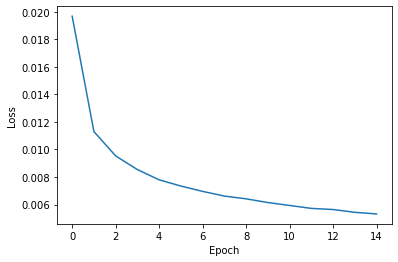

In [11]:
plt.figure()
plt.plot(epoch_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.savefig('fashion_loss.png')
plt.show()

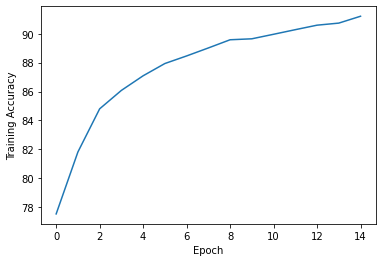

In [12]:
plt.figure()
plt.plot(train_acc)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
#plt.savefig('fashion_train_acc.png')
plt.show()

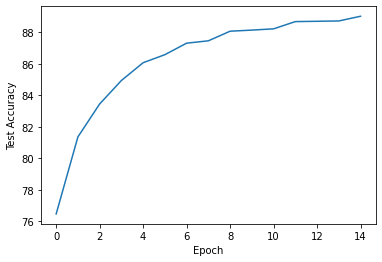

In [13]:
plt.figure()
plt.plot(test_acc)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
#plt.savefig('fashion_test_acc.png')
plt.show()